In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a directory to save the model and datasets
import os
model_dir = '/content/drive/MyDrive/models'
os.makedirs(model_dir, exist_ok=True)
print(f"Model directory created at {model_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model directory created at /content/drive/MyDrive/models


In [ ]:
# Step 2: Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import warnings
import time
from scipy.stats import randint, uniform
from scipy import stats

warnings.filterwarnings('ignore')


In [ ]:
# Step 3: Load and examine the dataset
# Adjust this path to where you've stored the data file in your Google Drive
df = pd.read_csv('/content/drive/MyDrive/UsedCarsSA_Clean_EN.csv')

# Display basic information about the dataset
print("First few rows of the dataset:")
display(df.head())

# Make a copy of the original dataset for later use
df_original = df.copy()

First few rows of the dataset:


,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Price,Negotiable
0,Chrysler,C300,2018,Saudi,Black,Full,5.7,Gas,Automatic,103000,Riyadh,114000,False
1,Nissan,Patrol,2016,Saudi,White,Full,4.8,Gas,Automatic,5448,Riyadh,0,True
2,Nissan,Sunny,2019,Saudi,Silver,Standard,1.5,Gas,Automatic,72418,Riyadh,27500,False
3,Hyundai,Elantra,2019,Saudi,Grey,Standard,1.6,Gas,Automatic,114154,Riyadh,43000,False
4,Hyundai,Elantra,2019,Saudi,Silver,Semi Full,2.0,Gas,Automatic,41912,Riyadh,59500,False


In [ ]:
# Step 4: Explore dataset information
print("\nDataset Information:")
df.info()



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         8035 non-null   object 
 1   Type         8035 non-null   object 
 2   Year         8035 non-null   int64  
 3   Origin       8035 non-null   object 
 4   Color        8035 non-null   object 
 5   Options      8035 non-null   object 
 6   Engine_Size  8035 non-null   float64
 7   Fuel_Type    8035 non-null   object 
 8   Gear_Type    8035 non-null   object 
 9   Mileage      8035 non-null   int64  
 10  Region       8035 non-null   object 
 11  Price        8035 non-null   int64  
 12  Negotiable   8035 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 761.3+ KB


In [ ]:
# Step 5: Generate descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,Year,Engine_Size,Mileage,Price
count,8035.000000,8035.000000,8.035000e+03,8.035000e+03
mean,2014.097698,3.287729,1.491488e+05,5.369984e+04
std,5.757228,1.517747,3.474480e+05,7.198472e+04
min,1963.000000,1.000000,1.000000e+02,0.000000e+00
25%,2012.000000,2.000000,3.700000e+04,0.000000e+00
50%,2016.000000,3.000000,1.019600e+05,3.700000e+04
75%,2018.000000,4.400000,1.950000e+05,7.375000e+04
max,2022.000000,9.000000,2.000000e+07,1.150000e+06


In [ ]:
# Step 6: Check for missing values and duplicates
print("\nMissing values in each column:")
print(df.isnull().sum())

print(f"\nNumber of duplicated rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicated rows after removal: {df.duplicated().sum()}")



Missing values in each column:
Make           0
Type           0
Year           0
Origin         0
Color          0
Options        0
Engine_Size    0
Fuel_Type      0
Gear_Type      0
Mileage        0
Region         0
Price          0
Negotiable     0
dtype: int64

Number of duplicated rows: 3
Number of duplicated rows after removal: 0


In [ ]:
# Step 7: Data cleaning and outlier removal
# Drop the Negotiable column and records with Price=0
df.drop(columns='Negotiable', inplace=True)  # Drop the Negotiable column as it has no effect
df = df[df.Price > 0]  # Exclude records with Price = 0

# Identify and remove extreme outliers using Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    filtered_entries = z_scores < threshold
    print(f"Removed {len(df) - sum(filtered_entries)} outliers from {column}")
    return df[filtered_entries]

# Apply outlier removal to Price
df = remove_outliers_zscore(df, 'Price')

# Apply outlier removal to Mileage
df = remove_outliers_zscore(df, 'Mileage')

# Check for extreme Engine_Size values
df = remove_outliers_zscore(df, 'Engine_Size')

print("\nDataset statistics after cleaning and outlier removal:")
display(df.describe())

Removed 109 outliers from Price
Removed 20 outliers from Mileage
Removed 43 outliers from Engine_Size

Dataset statistics after cleaning and outlier removal:


,Year,Engine_Size,Mileage,Price
count,5334.000000,5334.000000,5.334000e+03,5334.00000
mean,2014.818898,3.107743,1.279623e+05,71391.50375
std,5.114461,1.382780,1.116220e+05,53479.64519
min,1963.000000,1.000000,1.000000e+02,1.00000
25%,2013.000000,2.000000,4.900000e+04,35000.00000
50%,2016.000000,2.700000,1.020000e+05,57000.00000
75%,2018.000000,4.000000,1.807385e+05,90000.00000
max,2021.000000,7.500000,1.100000e+06,300000.00000


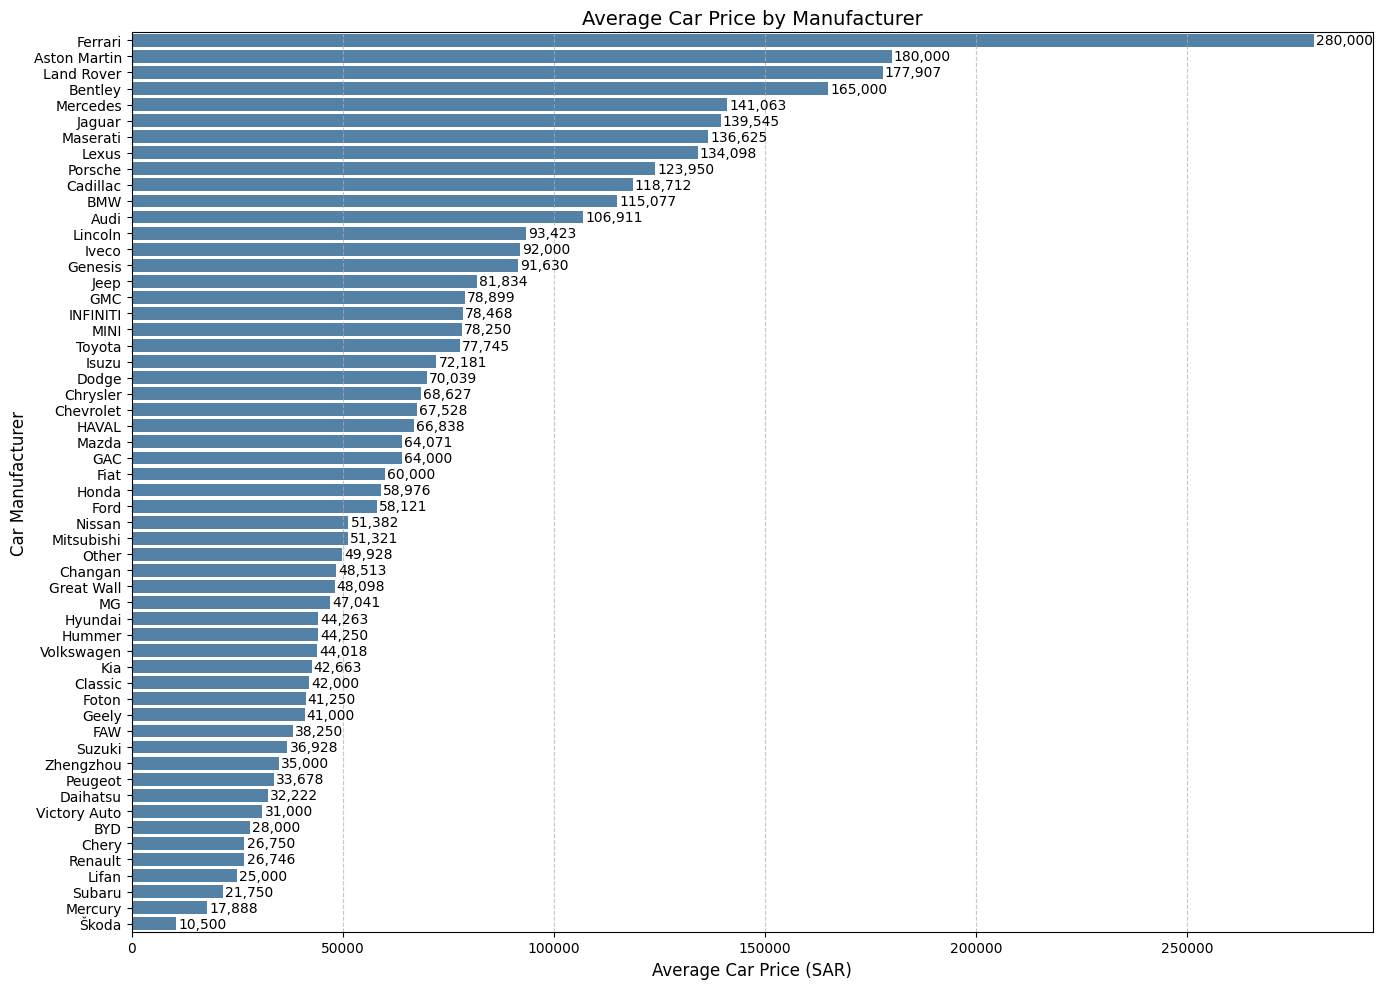

In [ ]:
# Step 8: Exploratory Data Analysis (EDA) - Price by manufacturer
# Visualize which manufacturer type has the highest price
make_vs_price = df.groupby('Make')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 10))
ax = sns.barplot(x=make_vs_price.values, y=make_vs_price.index, color='steelblue', legend=False)
plt.xlabel('Average Car Price (SAR)', fontsize=12)
plt.ylabel('Car Manufacturer', fontsize=12)
plt.title('Average Car Price by Manufacturer', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels to the bars
for i, v in enumerate(make_vs_price.values):
    ax.text(v + 500, i, f"{int(v):,}", va='center')

plt.tight_layout()
plt.show()

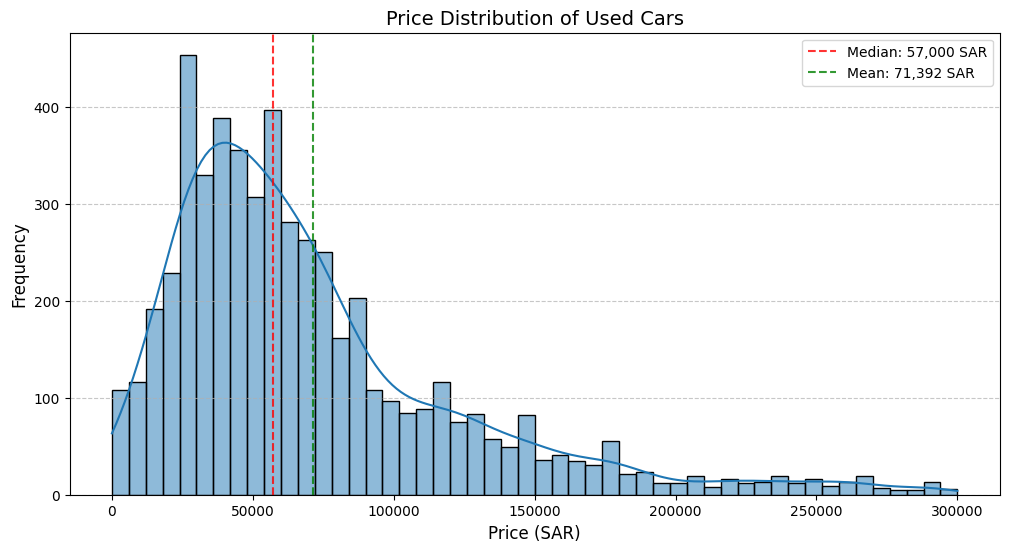

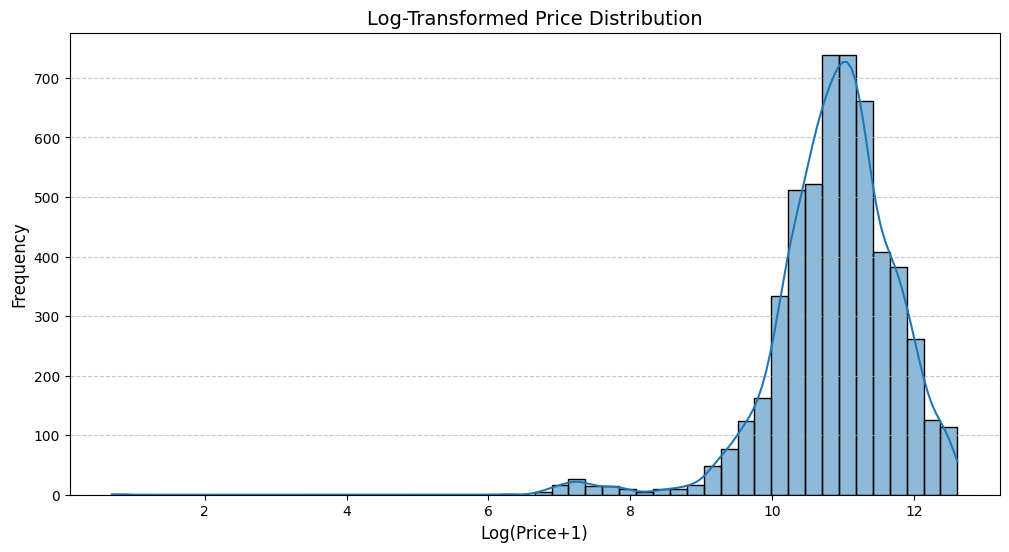

In [ ]:
# Step 9: EDA - Price distribution
plt.figure(figsize=(12, 6))
ax = sns.histplot(df.Price, bins=50, kde=True)
plt.title('Price Distribution of Used Cars', fontsize=14)
plt.xlabel('Price (SAR)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add median and mean lines
median_price = df.Price.median()
mean_price = df.Price.mean()
plt.axvline(median_price, color='red', linestyle='--', alpha=0.8,
            label=f'Median: {median_price:,.0f} SAR')
plt.axvline(mean_price, color='green', linestyle='--', alpha=0.8,
            label=f'Mean: {mean_price:,.0f} SAR')
plt.legend()
plt.show()

# Test log transformation on price
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df.Price), bins=50, kde=True)
plt.title('Log-Transformed Price Distribution', fontsize=14)
plt.xlabel('Log(Price+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Step 10: Feature Engineering
print("\nPerforming feature engineering...")

# 1. Create Car Age feature
current_year = 2025
df['Car_Age'] = current_year - df['Year']

# 2. Create PricePerKm (inverse of mileage) - handling div by zero
df['PricePerKm'] = df['Price'] / df['Mileage'].replace(0, 0.001)

# 3. Create Car Category features
def categorize_make(make):
    luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 'Land Rover', 'Jaguar',
                     'Bentley', 'Rolls-Royce', 'Cadillac', 'Maserati', 'Lamborghini', 'Ferrari']
    budget_brands = ['Kia', 'Hyundai', 'Geely', 'Chery', 'Suzuki', 'Daihatsu', 'Faw', 'Byd', 'Great Wall']

    if make in luxury_brands:
        return 'Luxury'
    elif make in budget_brands:
        return 'Budget'
    else:
        return 'Standard'

df['Make_Category'] = df['Make'].apply(categorize_make)

# 4. Create Size Category based on Engine_Size
def categorize_engine(size):
    if size < 1.5:
        return 'Small'
    elif size < 2.5:
        return 'Medium'
    elif size < 4.0:
        return 'Large'
    else:
        return 'Very Large'

df['Engine_Category'] = df['Engine_Size'].apply(categorize_engine)

# 5. Create Mileage Category
def categorize_mileage(miles):
    if miles < 50000:
        return 'Low'
    elif miles < 100000:
        return 'Medium'
    elif miles < 150000:
        return 'High'
    else:
        return 'Very High'

df['Mileage_Category'] = df['Mileage'].apply(categorize_mileage)

# Display engineered features
print("\nDataset after feature engineering:")
display(df.head())
print(f"Dataset shape: {df.shape}")



Performing feature engineering...

Dataset after feature engineering:


,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Price,Car_Age,PricePerKm,Make_Category,Engine_Category,Mileage_Category
0,Chrysler,C300,2018,Saudi,Black,Full,5.7,Gas,Automatic,103000,Riyadh,114000,7,1.106796,Standard,Very Large,High
2,Nissan,Sunny,2019,Saudi,Silver,Standard,1.5,Gas,Automatic,72418,Riyadh,27500,6,0.379740,Standard,Medium,Medium
3,Hyundai,Elantra,2019,Saudi,Grey,Standard,1.6,Gas,Automatic,114154,Riyadh,43000,6,0.376684,Budget,Medium,High
4,Hyundai,Elantra,2019,Saudi,Silver,Semi Full,2.0,Gas,Automatic,41912,Riyadh,59500,6,1.419641,Budget,Medium,Low
5,Honda,Accord,2018,Saudi,Navy,Full,1.5,Gas,Automatic,39000,Riyadh,72000,7,1.846154,Standard,Medium,Low


Dataset shape: (5334, 17)


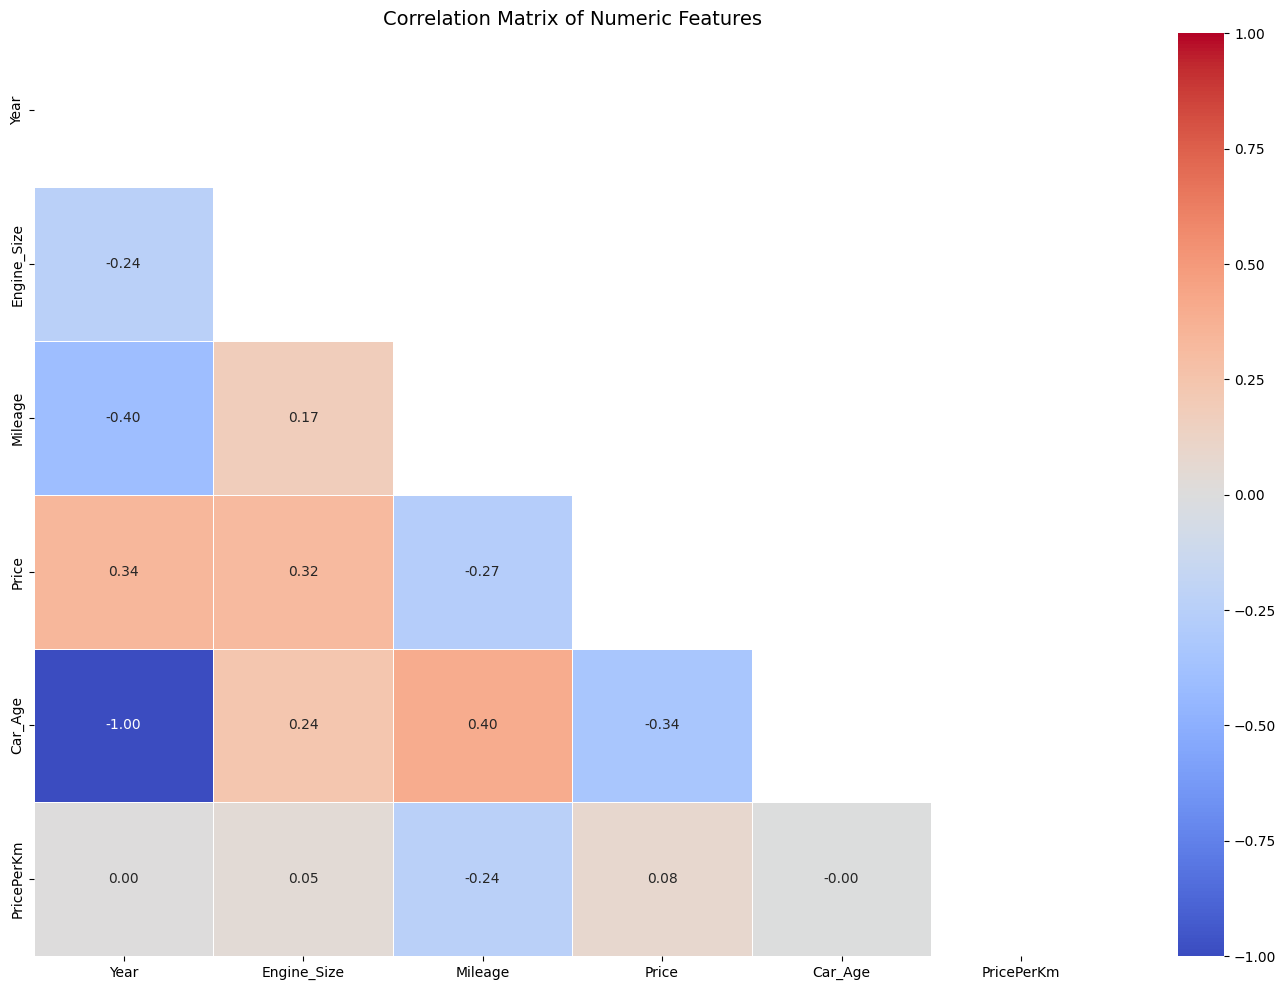

In [ ]:
# Step 11: EDA - Correlation analysis of numeric features
# Select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Step 12: Prepare for modeling - Define features and target
# Define categorical features and numerical features
categorical_features = ['Make', 'Type', 'Origin', 'Color', 'Options', 'Gear_Type',
                       'Fuel_Type', 'Region', 'Make_Category', 'Engine_Category', 'Mileage_Category']
numerical_features = ['Year', 'Engine_Size', 'Mileage', 'Car_Age', 'PricePerKm']

# Save the original dataset structure for later use
original_columns = list(df.columns)
with open('/content/drive/MyDrive/models/original_columns.pkl', 'wb') as f:
    pickle.dump(original_columns, f)

# Save categorical values for each feature (for the web app dropdown menus)
categorical_values = {}
for feature in categorical_features:
    categorical_values[feature] = sorted(df[feature].unique().tolist())

with open('/content/drive/MyDrive/models/categorical_values.pkl', 'wb') as f:
    pickle.dump(categorical_values, f)

# Apply label encoding to categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Save the label encoders for use in the web app
with open('/content/drive/MyDrive/models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Prepare the target variable with a log transformation for better modeling
y = df['Price'].values
y_log = np.log1p(df['Price'].values)  # log(1+x) transformation

# Prepare features
X = df.drop(['Price', 'PricePerKm'], axis=1)  # PricePerKm is derived from Price, so drop it

# Update feature list for the model
feature_list = list(X.columns)

In [ ]:
# Step 13: Split data into train-validation-test sets
# First split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test, y_log_train_val, y_log_test = train_test_split(
    X, y, y_log, test_size=0.2, random_state=42)

# Then split training set into training and validation
X_train, X_val, y_train, y_val, y_log_train, y_log_val = train_test_split(
    X_train_val, y_train_val, y_log_train_val, test_size=0.25, random_state=42)

print("Dataset splits:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

# Store test indices for creating readable test set later
test_indices = X_test.index

Dataset splits:
X_train: (3200, 15)
X_val: (1067, 15)
X_test: (1067, 15)


In [ ]:
# Step 14: Model training and evaluation function

def evaluate_model(model, X_train, X_val, y_train, y_val, is_log_target=False):
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_val)

    # If log-transformed, convert predictions back to original scale
    if is_log_target:
        y_pred = np.expm1(y_pred)  # inverse of log1p

    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    # Cross-validation score
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = 'neg_root_mean_squared_error'

    if is_log_target:
        # For log-transformed target, we need to handle CV differently
        cv_scores = []
        for train_idx, test_idx in cv.split(X_train):
            X_cv_train, X_cv_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_cv_train, y_cv_test = y_train[train_idx], y_train[test_idx]  # FIXED: y_val -> y_train

            # Train model on CV split
            model.fit(X_cv_train, y_cv_train)

            # Predict and convert back to original scale
            y_cv_pred = model.predict(X_cv_test)
            if is_log_target:
                y_cv_pred = np.expm1(y_cv_pred)

            # Calculate RMSE
            cv_rmse = np.sqrt(mean_squared_error(y_cv_test, y_cv_pred))
            cv_scores.append(-cv_rmse)  # Negative for compatibility with sklearn's neg_rmse

        cv_rmse = -np.mean(cv_scores)
    else:
        # Standard CV for non-transformed target
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        cv_rmse = -cv_scores.mean()

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV_RMSE': cv_rmse,
        'Training_Time': training_time,
        'Model': model,
        'Predictions': y_pred,
        'Is_Log_Target': is_log_target
    }

In [ ]:
# Step 15: Define and train different models
print("\nTraining and evaluating models...")

models_regular = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

models_log = {
    'Linear Regression (Log)': LinearRegression(),
    'Random Forest (Log)': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting (Log)': GradientBoostingRegressor(n_estimators=100, random_state=42)
}


# Train and evaluate models with regular target
results_regular = {}
for name, model in models_regular.items():
    print(f"Training {name}...")
    results = evaluate_model(model, X_train, X_val, y_train, y_val, is_log_target=False)
    results_regular[name] = results
    print(f"{name} - RMSE: {results['RMSE']:.2f}, R²: {results['R2']:.4f}, Time: {results['Training_Time']:.2f}s")

# Train and evaluate models with log-transformed target
results_log = {}
for name, model in models_log.items():
    print(f"Training {name}...")
    results = evaluate_model(model, X_train, X_val, y_log_train, y_log_val, is_log_target=True)
    results_log[name] = results
    print(f"{name} - RMSE: {results['RMSE']:.2f}, R²: {results['R2']:.4f}, Time: {results['Training_Time']:.2f}s")

# Combine results
all_results = {**results_regular, **results_log}

# Create a DataFrame with the results for easy comparison
results_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'MAE': [result['MAE'] for result in all_results.values()],
    'RMSE': [result['RMSE'] for result in all_results.values()],
    'R2': [result['R2'] for result in all_results.values()],
    'CV_RMSE': [result['CV_RMSE'] for result in all_results.values()],
    'Training_Time': [result['Training_Time'] for result in all_results.values()]
})

# Round the results for better readability
results_df = results_df.round(2)
print("\nModel Performance Comparison:")
display(results_df.sort_values('R2', ascending=False))


Training and evaluating models...
Training Linear Regression...
Linear Regression - RMSE: 40466.29, R²: 0.4152, Time: 0.01s
Training Random Forest...
Random Forest - RMSE: 22741.71, R²: 0.8153, Time: 3.17s
Training Gradient Boosting...
Gradient Boosting - RMSE: 25350.98, R²: 0.7705, Time: 0.49s
Training Linear Regression (Log)...
Linear Regression (Log) - RMSE: 66751.13, R²: -6596452215.7435, Time: 0.00s
Training Random Forest (Log)...
Random Forest (Log) - RMSE: 76487.28, R²: -8661071175.9491, Time: 2.43s
Training Gradient Boosting (Log)...
Gradient Boosting (Log) - RMSE: 70841.10, R²: -7429571468.3253, Time: 0.48s

Model Performance Comparison:


,Model,MAE,RMSE,R2,CV_RMSE,Training_Time
1,Random Forest,13964.61,22741.71,8.200000e-01,25253.35,3.17
2,Gradient Boosting,16313.65,25350.98,7.700000e-01,26570.73,0.49
0,Linear Regression,28233.65,40466.29,4.200000e-01,40397.32,0.01
3,Linear Regression (Log),59975.40,66751.13,-6.596452e+09,65743.58,0.00
5,Gradient Boosting (Log),61003.73,70841.10,-7.429571e+09,73263.23,0.48
4,Random Forest (Log),62806.39,76487.28,-8.661071e+09,78033.31,2.43


In [ ]:
# Step 16: Hyperparameter tuning for the best models

top_regular_model_name = results_df[~results_df['Model'].str.contains('Log')].sort_values('R2', ascending=False).iloc[0]['Model']
top_log_model_name = results_df[results_df['Model'].str.contains('Log')].sort_values('R2', ascending=False).iloc[0]['Model']

print(f"\nBest regular model: {top_regular_model_name}")
print(f"Best log-transformed model: {top_log_model_name}")

# Regular model setup
if 'Random Forest' in top_regular_model_name:
    param_grid_regular = {
        'n_estimators': randint(100, 500),
        'max_depth': [None] + list(randint(5, 30).rvs(5)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    }
    base_model_regular = RandomForestRegressor(random_state=42)
elif 'Gradient Boosting' in top_regular_model_name:
    param_grid_regular = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 12),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    }
    base_model_regular = GradientBoostingRegressor(random_state=42)
else:
    raise ValueError(f"Unexpected regular model for tuning: {top_regular_model_name}")

# Log-transformed model setup
if 'Random Forest' in top_log_model_name:
    param_grid_log = {
        'n_estimators': randint(100, 500),
        'max_depth': [None] + list(randint(5, 30).rvs(5)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    }
    base_model_log = RandomForestRegressor(random_state=42)
elif 'Gradient Boosting' in top_log_model_name:
    param_grid_log = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 12),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    }
    base_model_log = GradientBoostingRegressor(random_state=42)
elif 'Linear Regression' in top_log_model_name:
    # No hyperparameters to tune for LinearRegression, so skip tuning
    base_model_log = LinearRegression()
    param_grid_log = None
else:
    raise ValueError(f"Unexpected log model for tuning: {top_log_model_name}")

print("\nPerforming hyperparameter tuning for top models...")

# Tuning regular model
print(f"Tuning {top_regular_model_name}...")
search_regular = RandomizedSearchCV(
    base_model_regular,
    param_distributions=param_grid_regular,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
search_regular.fit(X_train, y_train)
best_regular_model = search_regular.best_estimator_
print(f"Best parameters for {top_regular_model_name}: {search_regular.best_params_}")
print(f"Best R² score: {search_regular.best_score_:.4f}")

# Tuning log-transformed model or just fit if Linear Regression
print(f"\nTuning {top_log_model_name}...")
if param_grid_log is not None:
    search_log = RandomizedSearchCV(
        base_model_log,
        param_distributions=param_grid_log,
        n_iter=30,
        cv=5,
        scoring='r2',
        random_state=42,
        n_jobs=-1
    )
    search_log.fit(X_train, y_log_train)
    best_log_model = search_log.best_estimator_
    print(f"Best parameters for {top_log_model_name}: {search_log.best_params_}")
    print(f"Best R² score: {search_log.best_score_:.4f}")
else:
    # Just fit the Linear Regression model without tuning
    base_model_log.fit(X_train, y_log_train)
    best_log_model = base_model_log
    print(f"{top_log_model_name} has no hyperparameters to tune.")



Best regular model: Random Forest
Best log-transformed model: Linear Regression (Log)

Performing hyperparameter tuning for top models...
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': np.int64(26), 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 330}
Best R² score: 0.7622

Tuning Linear Regression (Log)...
Linear Regression (Log) has no hyperparameters to tune.


In [ ]:
# Step 17: Evaluate the best models on validation set
# Evaluate regular model
y_val_pred_regular = best_regular_model.predict(X_val)
val_r2_regular = r2_score(y_val, y_val_pred_regular)
val_rmse_regular = np.sqrt(mean_squared_error(y_val, y_val_pred_regular))
val_mae_regular = mean_absolute_error(y_val, y_val_pred_regular)

# Evaluate log model - need to transform predictions back
y_val_pred_log = np.expm1(best_log_model.predict(X_val))
val_r2_log = r2_score(y_val, y_val_pred_log)
val_rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred_log))
val_mae_log = mean_absolute_error(y_val, y_val_pred_log)

print("\nValidation Set Performance:")
print(f"Regular Model - R²: {val_r2_regular:.4f}, RMSE: {val_rmse_regular:.2f}, MAE: {val_mae_regular:.2f}")
print(f"Log Model - R²: {val_r2_log:.4f}, RMSE: {val_rmse_log:.2f}, MAE: {val_mae_log:.2f}")

# Determine the overall best model based on validation R²
if val_r2_regular > val_r2_log:
    best_model = best_regular_model
    best_model_name = top_regular_model_name + " (Tuned)"
    is_log_model = False
    print(f"\nSelected model: {best_model_name} (Regular model)")
else:
    best_model = best_log_model
    best_model_name = top_log_model_name + " (Tuned)"
    is_log_model = True
    print(f"\nSelected model: {best_model_name} (Log-transformed model)")



Validation Set Performance:
Regular Model - R²: 0.8163, RMSE: 22680.32, MAE: 13993.78
Log Model - R²: 0.4186, RMSE: 40348.37, MAE: 25297.30

Selected model: Random Forest (Tuned) (Regular model)


In [ ]:
# Step 18: Evaluate the best model on test set
# Make predictions on test set
if is_log_model:
    y_test_pred = np.expm1(best_model.predict(X_test))
else:
    y_test_pred = best_model.predict(X_test)

# Calculate metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTest Set Performance for {best_model_name}:")
print(f"Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f}")
print(f"R² Score: {test_r2:.4f}")



Test Set Performance for Random Forest (Tuned):
Mean Absolute Error (MAE): 14482.86
Root Mean Squared Error (RMSE): 24863.93
R² Score: 0.7968


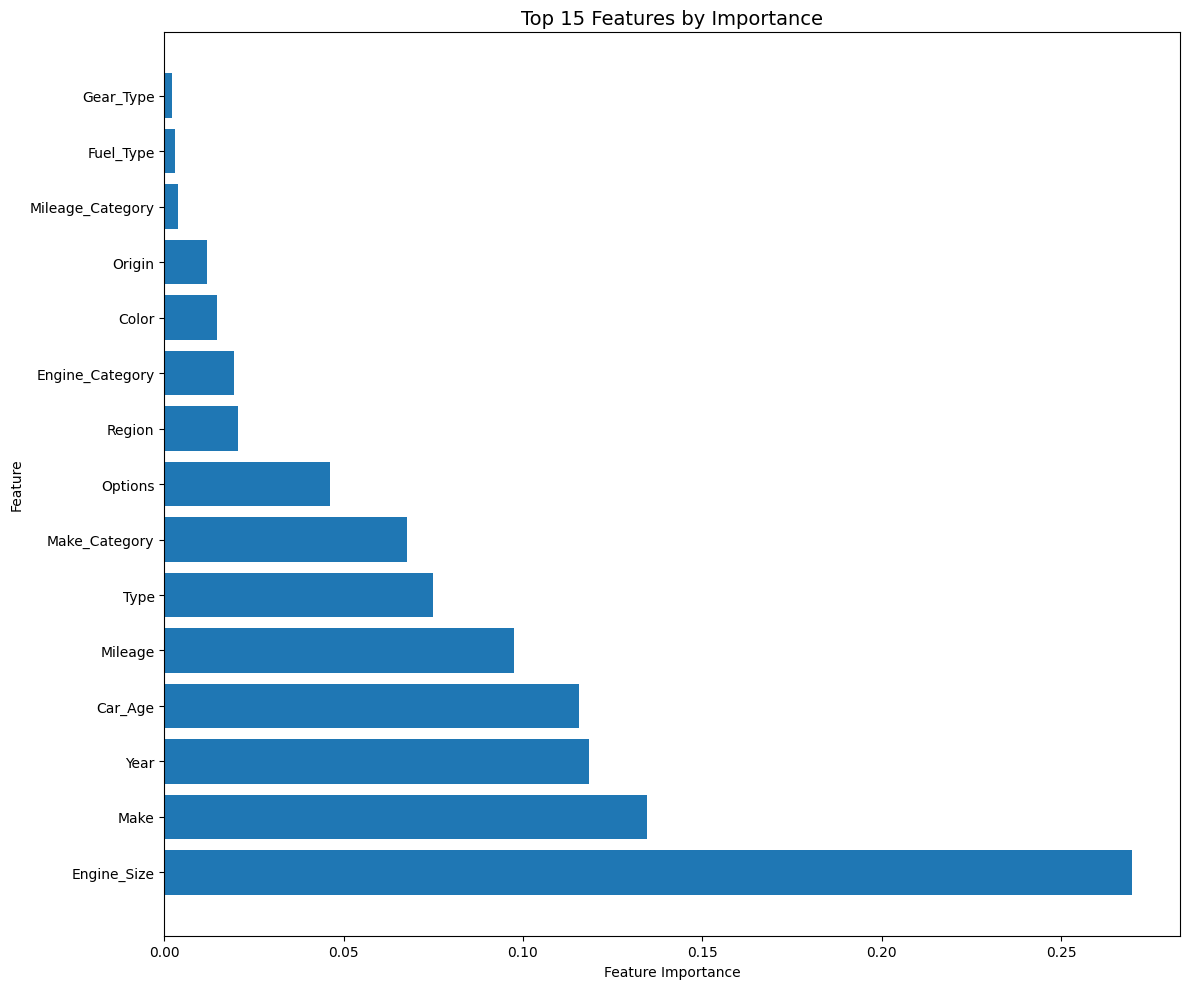

Top 15 Features:
1. Engine_Size: 0.2697
2. Make: 0.1345
3. Year: 0.1185
4. Car_Age: 0.1157
5. Mileage: 0.0976
6. Type: 0.0749
7. Make_Category: 0.0676
8. Options: 0.0463
9. Region: 0.0205
10. Engine_Category: 0.0195
11. Color: 0.0147
12. Origin: 0.0120
13. Mileage_Category: 0.0037
14. Fuel_Type: 0.0030
15. Gear_Type: 0.0020


In [ ]:
# Step 20: Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Select top features
    num_features = min(20, len(X_train.columns))
    top_indices = indices[:num_features]
    top_importances = importances[top_indices]
    top_feature_names = X_train.columns[top_indices]

    # Plot feature importances
    plt.figure(figsize=(12, 10))
    plt.barh(range(num_features), top_importances, align="center")
    plt.yticks(range(num_features), top_feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {num_features} Features by Importance", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Save the top feature names for the web app
    with open('/content/drive/MyDrive/models/top_features.pkl', 'wb') as f:
        pickle.dump(list(top_feature_names), f)

    print(f"Top {num_features} Features:")
    for i, feature in enumerate(top_feature_names):
        print(f"{i+1}. {feature}: {top_importances[i]:.4f}")


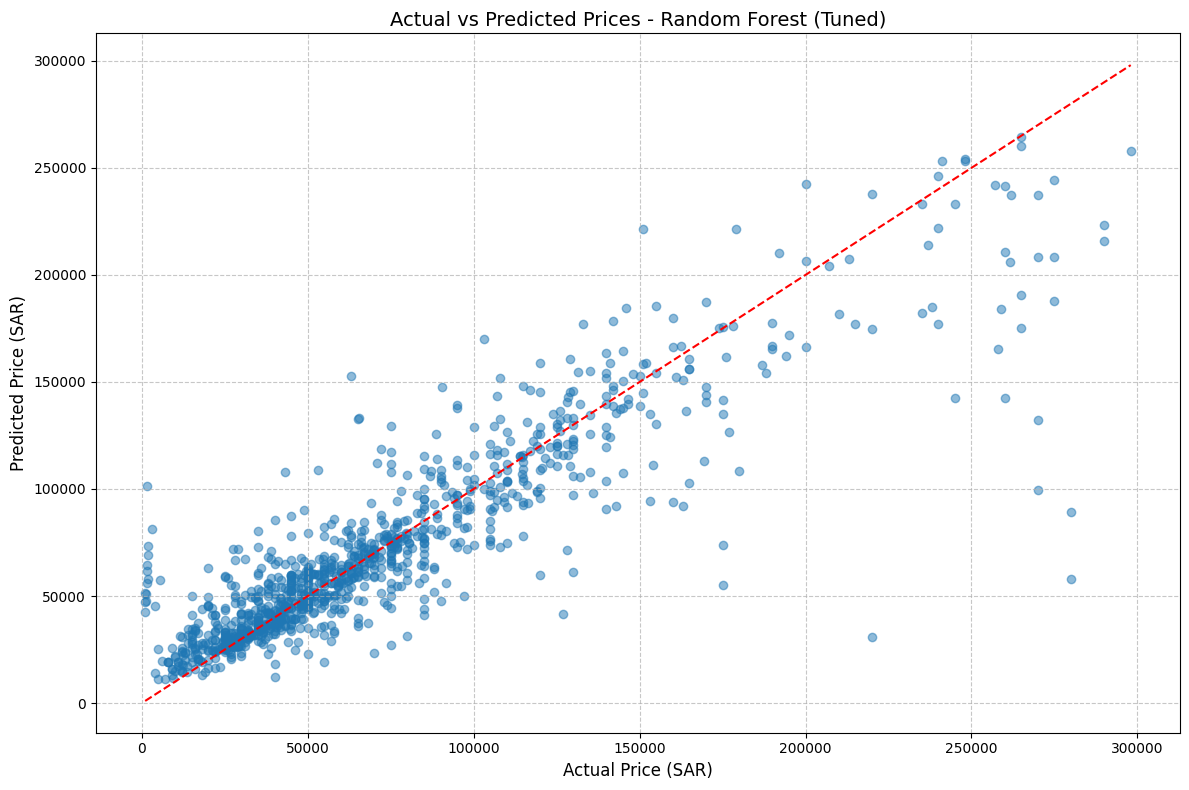

In [ ]:
# Step 20: Visualize actual vs predicted values on test data
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title(f'Actual vs Predicted Prices - {best_model_name}', fontsize=14)
plt.xlabel('Actual Price (SAR)', fontsize=12)
plt.ylabel('Predicted Price (SAR)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Step 21: Create a human-readable test dataset for the web app
# Get original values for test samples
test_df_readable = df_original.loc[test_indices].copy()

# If we added new features in the original dataframe, make sure they're in test_df_readable too
if 'Car_Age' not in test_df_readable.columns:
    test_df_readable['Car_Age'] = current_year - test_df_readable['Year']

if 'Make_Category' not in test_df_readable.columns:
    test_df_readable['Make_Category'] = test_df_readable['Make'].apply(categorize_make)

if 'Engine_Category' not in test_df_readable.columns:
    test_df_readable['Engine_Category'] = test_df_readable['Engine_Size'].apply(categorize_engine)

if 'Mileage_Category' not in test_df_readable.columns:
    test_df_readable['Mileage_Category'] = test_df_readable['Mileage'].apply(categorize_mileage)

# Add the predictions
test_df_readable['Predicted_Price'] = y_test_pred
test_df_readable['Error'] = test_df_readable['Price'] - test_df_readable['Predicted_Price']
test_df_readable['Error_Percentage'] = (test_df_readable['Error'] / test_df_readable['Price']) * 100

# Save the human-readable test dataset
test_df_readable.to_csv('/content/drive/MyDrive/models/test_dataset_readable.csv', index=False)
print("\nHuman-readable test dataset saved to: /content/drive/MyDrive/models/test_dataset_readable.csv")

# Display sample records
print("\nSample readable test data (5 records):")
display(test_df_readable[['Make', 'Type', 'Year', 'Price', 'Predicted_Price', 'Error', 'Error_Percentage']].head(5))



Human-readable test dataset saved to: /content/drive/MyDrive/models/test_dataset_readable.csv

Sample readable test data (5 records):


,Make,Type,Year,Price,Predicted_Price,Error,Error_Percentage
1394,Ford,Mustang,2016,97000,90822.587729,6177.412271,6.368466
6267,Nissan,Datsun,1989,11000,19251.438259,-8251.438259,-75.013075
4114,Chrysler,300,2014,57000,62458.419330,-5458.419330,-9.576174
959,Mazda,CX9,2015,48000,67701.938289,-19701.938289,-41.045705
187,Hyundai,Kona,2019,77000,54679.485951,22320.514049,28.987681


In [ ]:
# Step 22: Check specific examples
# Check prediction for Chevrolet Cruze 2016
if 'Make' in test_df_readable.columns:
    chevrolet_examples = test_df_readable[
        (test_df_readable['Make'] == 'Chevrolet') &
        (test_df_readable['Type'] == 'Cruze') &
        (test_df_readable['Year'] >= 2015) &
        (test_df_readable['Year'] <= 2017)
    ]

    if not chevrolet_examples.empty:
        print("\nChevrolet Cruze Examples:")
        display(chevrolet_examples[['Make', 'Type', 'Year', 'Mileage', 'Price', 'Predicted_Price', 'Error_Percentage']])
    else:
        print("\nNo Chevrolet Cruze examples in the test set.")

        # Try to find at least one Chevrolet
        chevrolet_any = test_df_readable[test_df_readable['Make'] == 'Chevrolet']
        if not chevrolet_any.empty:
            print("Other Chevrolet examples:")
            display(chevrolet_any[['Make', 'Type', 'Year', 'Mileage', 'Price', 'Predicted_Price', 'Error_Percentage']].head(3))



Chevrolet Cruze Examples:


,Make,Type,Year,Mileage,Price,Predicted_Price,Error_Percentage
471,Chevrolet,Cruze,2016,52000,45000,58944.485800,-30.987746
5943,Chevrolet,Cruze,2016,136000,25000,59424.246576,-137.696986


In [ ]:
# Step 23: Save the best model
# We need to save additional info if it's a log-transformed model
model_path = '/content/drive/MyDrive/models/car_price_prediction_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\nBest model ({best_model_name}) saved to: {model_path}")



Best model (Random Forest (Tuned)) saved to: /content/drive/MyDrive/models/car_price_prediction_model.pkl


In [ ]:
# Step 24: Save model info
model_info = {
    'model_name': best_model_name,
    'features': feature_list,
    'metrics': {
        'mae': test_mae,
        'rmse': test_rmse,
        'r2': test_r2
    },
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'original_columns': original_columns,
    'label_encoders': label_encoders,
    'is_log_model': is_log_model,
    'engineered_features': {
        'car_age_function': 'current_year - Year',
        'make_category_function': 'categorize_make',
        'engine_category_function': 'categorize_engine',
        'mileage_category_function': 'categorize_mileage'
    }
}

info_path = '/content/drive/MyDrive/models/model_info.pkl'
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f"Model information saved to: {info_path}")

print("\nModel training and evaluation complete!")

Model information saved to: /content/drive/MyDrive/models/model_info.pkl

Model training and evaluation complete!
